In [3]:
import datetime
import time
from tqdm import tqdm
import requests
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
from sec_api import ExtractorApi
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy
spacy_model = spacy.load("en_core_web_sm")
from textblob import TextBlob
import bisect
import math
import openpyxl
import multiprocessing

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
def get_ciks():
    with open("cik_list.txt", "r") as cik_list:
      lines = cik_list.readlines()
      ciks = lines[0].split(',')
      for i, cik in enumerate(ciks):
        ciks[i] = str(int(cik))
      return ciks
        
START_YEAR = 2000
END_YEAR = 2005
# CIKS = ['789019', '320193']
CIKS = get_ciks()
headers = {
    'User-Agent': 'sean.wareing@eccles.utah.edu',
    'Accept-Encoding': 'gzip, deflate',
    'Host': 'www.sec.gov'
}
output_dir = os.getcwd() # Make sure to give path in the following pattern: C:\Users\HP\Desktop\Edgar

extractorApi = ExtractorApi("2b81445ea2ba1eb88b9d2c9b90831c26c20caa66a218b6ff7f7852cf9a0ebebd")

In [5]:
def get_urls_df():
    print("Getting Urls...")
    urlsPresent = os.path.isfile(os.path.join('./', 'urls_df.csv'))
    
    if urlsPresent:
        df = pd.read_csv('urls_df.csv')
    else:
      current_quarter = (datetime.date.today().month - 1) // 3 + 1
      years = list(range(START_YEAR, END_YEAR+1))
      quarters = ['QTR1', 'QTR2', 'QTR3', 'QTR4']
      history = [(y, q) for y in years for q in quarters]
      for i in range(1, current_quarter + 1):
          history.append((END_YEAR, 'QTR%d' % i))
      urls = ['https://www.sec.gov/Archives/edgar/full-index/%d/%s/crawler.idx' % (x[0], x[1]) for x in history]
      urls.sort()
    
      rows = []
      for url in tqdm(urls):
          lines = requests.get(url, headers = headers).text.splitlines()
          for line in range(9, len(lines)):
              row = lines[line].split('  ')
              row = [i.strip() for i in row if i]
              if CIKS:  # Checking for required CIKs
                  if row[1] == '10-K' and row[2] in CIKS:
                      rows.append(row[:5])
              else:
                  # print('here')
                  if row[1] == '10-K':
                      # print('here')
                      rows.append(row[:5])
          time.sleep(.15)
    
      cols = ['C_Name', 'F_type', 'CIK', 'Date_Filed', 'URL']
      df = pd.DataFrame(rows, columns=cols)
      df.to_csv('urls_df.csv')
    print("Total Forms: ", len(df))
    return df

In [22]:
def get_filing_urls(df):
    print("Getting main filing's Urls...")
    main1_present = os.path.isfile(os.path.join('./', 'main1_df.csv'))
    
    if main1_present:
        main1_df = pd.read_csv('main1_df.csv')
        main1 = main1_df.values.tolist()
    else:
        empty_forms = []
        main1 = []
        for row, url in tqdm(enumerate(df['URL'])):
          data = requests.get(url, headers=headers)
          soup = BeautifulSoup(data.text, 'html.parser')
          table_rows = soup.find_all('tr')
          try:
              cells = table_rows[-1].find_all('td')
          except:
              cells = []
          link_address = ''
          for cell in cells:
            anchor = cell.find('a')
            if anchor:
              link_address = anchor['href']
              if link_address:
                link_address = 'https://www.sec.gov' + link_address
        
          # if df['F_type'][row] == '10-K':
          if link_address != 'https://www.sec.gov':
              main1.append([df['CIK'][row], df['Date_Filed'][row], link_address])
        
          time.sleep(.1)
        main1_df = pd.DataFrame(main1, columns=['CIK', 'Date', 'Link'])
        main1_df.to_csv('main1_df.csv')
    return main1


In [23]:
CLEAN_TEXT_PATTERN = re.compile(r'[^\w\s.!?]')
WHITESPACE_PATTERN = re.compile(r'\s+')
PUNCTUATION_PATTERN = re.compile(r'([.!?])([A-Za-z])')
YEAR_PATTERN = re.compile(r'\b[12][90]\d{2}\b')

def clean_text(text):
    cleaned_text = CLEAN_TEXT_PATTERN.sub('', text)
    cleaned_text = WHITESPACE_PATTERN.sub(' ', cleaned_text)
    cleaned_text = PUNCTUATION_PATTERN.sub(r'\1 \2', cleaned_text)
    return cleaned_text.strip()

# def clean_text(text):
#     cleaned_text = re.sub(r'[^\w\s.!?]', '', text)
#     cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
#     cleaned_text = re.sub(r'([.!?])([A-Za-z])', r'\1 \2', cleaned_text)
#     cleaned_text = cleaned_text.strip()
#     return cleaned_text

# Variable 1 - Word Count
def word_count(text):
  section_wc = len(word_tokenize(text))
  return section_wc

# Variable 2 - Sentence Count
def sent_count(text):
  section_sc = len(sent_tokenize(text))
  return section_sc

def contains_forward_year(sentence, curr_year):
  year_pattern = r'\b[12][90]\d{2}\b' # 0 1 2 3 4 5 6 7 8 9 0 1 2... 1991 - 2009
  years = re.findall(year_pattern, sentence)
  result = []
  if years:
    for y in years:
      if int(y) > curr_year:
        result.append(int(y)-curr_year)
  return result

# Variables 3, 4, 5 - Forward Looking Intensity, Long Horizon Intensity, Short Horizon Intensity
ps = nltk.stem.PorterStemmer()
def forward_looking_intensity(text, year_filed):
  sentences = sent_tokenize(text)
  short_horizon_keywords = ['short term', 'month', 'months', 'current fiscal', 'current quarter', 'current year', 'current month', 'current period', 'following fiscal', 'following quarter', 'following month', 'following period', 'coming fiscal', 'coming quarter', 'coming month', 'coming period', 'next fiscal', 'next quarter', 'next month', 'next period', 'subsequent fiscal', 'subsequent quarter', 'subsequent month', 'subsequent period']
  long_horizon_keywords = ['century', 'decade', 'foreseeable future', 'long term', 'coming year', 'coming years', 'following year', 'following years', 'next year', 'next years', 'subsequent year', 'subsequent years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10 years', '11 years', '12 years', '13 years', '14 years', '15 years', '16 years', '17 years', '18 years', '19 years', '20 years']
  total_sentences = len(sentences)
  forward_looking_sentences = 0
  check1 = 0
  check2 = 0
  check3 = 0
  short_horizon_count = 0
  long_horizon_count = 0
    
  for sentence in sentences:
    sentence = sentence.lower()

    # Check 1: Check for the folowing forward looking phrases
    keywords = ["will", "future", "next fiscal", "next month", "next period", "next quarter", "next year", "incoming fiscal", "incoming month", "incoming period", "incoming quarter", "incoming year", "coming fiscal", "coming month", "coming period", "coming quarter", "coming year", "upcoming fiscal", "upcoming month", "upcoming period", "upcoming quarter", "upcoming year", "subsequent fiscal", "subsequent month", "subsequent period", "subsequent quarter", "subsequent year", "following fiscal", "following month", "following period", "following quarter", "following year"]
    if any(keyword in sentence for keyword in keywords):
      forward_looking_sentences += 1
      check1 += 1
      if any(keyword in sentence for keyword in short_horizon_keywords):
        short_horizon_count += 1
      elif any(keyword in sentence for keyword in long_horizon_keywords):
        long_horizon_count += 1
      continue

    # Check 2: Check for the forward looking verbs
    verbs = ["aim", "anticipate", "assume", "commit", "estimate", "expect", "forecast", "foresee", "hope", "intend", "plan", "project", "seek", "target"]
    for j, verb in enumerate(verbs):
      verbs[j] = ps.stem(verb)
    words = word_tokenize(sentence)
    temp = ""
    for word in words:
      temp += ps.stem(word) + " "
    if any(verb in temp for verb in verbs):
      forward_looking_sentences += 1
      check2 += 1
      if any(keyword in sentence for keyword in short_horizon_keywords):
        short_horizon_count += 1
      elif any(keyword in sentence for keyword in long_horizon_keywords):
        long_horizon_count += 1
      continue

    # Check 3: Check for any forward year
    years = contains_forward_year(sentence, year_filed)
    if years:
      forward_looking_sentences += 1
      check3 += 1
      if 1 in years:
        short_horizon_count += 1
        continue
      else:
        long_horizon_count += 1
        continue
      if any(keyword in sentence for keyword in short_horizon_keywords):
        short_horizon_count += 1
      elif any(keyword in sentence for keyword in long_horizon_keywords):
        long_horizon_count += 1

  return ['%.6f'%(forward_looking_sentences/total_sentences), '%.6f'%(long_horizon_count/total_sentences), '%.6f'%(short_horizon_count/total_sentences)]

# Variable 6: Sentiment Analysis
def split_text_into_chunks(text, chunk_size=1_000_000):
    words = text.split()  # Split the text into words
    num_chunks = math.ceil(len(words) / chunk_size)
    chunks = [' '.join(words[i * chunk_size: (i + 1) * chunk_size]) for i in range(num_chunks)]
    return chunks
    
def sentiment_analysis(text):
    chunks = split_text_into_chunks(text)
    sentiment_sum = 0
    for chunk in chunks:
        blob = TextBlob(chunk)
        sentiment_sum += blob.sentiment.polarity  
    average_sentiment = sentiment_sum / len(chunks)
    buckets = [-1.0, -0.75, -0.25, 0.25, 0.75, 1.0]
    labels = ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]
    index = bisect.bisect(buckets, average_sentiment) - 1
    return labels[index], average_sentiment

In [49]:
def perform_text_analysis(main1):
    print("Performing Text Analysis.....")
    dataset = []
    nan_links = []
    for idx, cik, date, link in tqdm(main1):
      if type(link) == float:
        nan_links.append([idx, cik, date, link])  
        continue
      data = requests.get(link, headers=headers)
      soup = BeautifulSoup(data.content, 'html.parser')
      entire_text = soup.get_text()
      cleaned_text = clean_text(entire_text)
      entire_wc = len(word_tokenize(cleaned_text))
      # ds = {'Entire':entire_wc, '1':-1, '1A':-1, '1B':-1, '1C':-1, '2':-1, '3':-1, '4':-1, '5':-1, '6':-1, '7':-1, '7A':-1, '8':-1, '9':-1, '9A':-1, '9B':-1, '10':-1, '11':-1, '12':-1, '13':-1, '14':-1, '15':-1}
      for item in ['1', '1A', '1B', '1C', '2', '3', '4', '5', '6', '7', '7A', '8', '9', '9A', '9B', '10', '11', '12', '13', '14', '15']:
        section_text = extractorApi.get_section(link, item, "text")
        if section_text:
          section_cleaned_text = clean_text(section_text)
          section_wc = word_count(section_cleaned_text)
          section_sc = sent_count(section_cleaned_text)
          section_sentiment, section_sentiment_score = sentiment_analysis(section_cleaned_text)
          section_fli, section_long_horizon, section_short_horizon = forward_looking_intensity(section_cleaned_text, int(date[:4]))
          dataset.append([cik, item, date[:4], section_wc, section_sc, section_fli, section_long_horizon, section_short_horizon, section_sentiment, section_sentiment_score, section_cleaned_text])
    dataset_df = pd.DataFrame(dataset, columns=['CIK', 'Item', 'Year', 'Word Count', 'Sentence Count', 'Forward Looking Intensity', 'Long Horizon Intensity', 'Short Horizon Intensity', 'Sentiment', 'Sentiment Score', 'Section Content'])
    nan_links_df = pd.DataFrame(nan_links)
    return dataset_df, nan_links_df

In [51]:
if __name__ == "__main__":
    with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
        print("Initiating processes")
        
        # Get URLs in parallel
        df_result = pool.apply_async(get_urls_df)
        df = df_result.get()
        print("Fetched Urls")
        
        # Fetch filings in parallel after df is ready
        main1_result = pool.apply_async(get_filing_urls, args=(df,))
        main1 = main1_result.get()
        print("Fetched Filing Urls")
        
        # Perform text analysis after main1 is ready
        result = pool.apply_async(perform_text_analysis, args=(main1[:3871],))
        dataset_df, nan_links_df = result.get()
        dataset_df.to_csv(f'text_analysis_{2000}.csv')
        nan_links_df.to_csv(f'nan_links_{2000}.csv')
        print("Done with textual analysis")

        pool.close()
        pool.join()
    
    
# df = get_urls_df()
# main1 = get_filing_urls(df)
# dataset_df, nan_links_df = perform_text_analysis(main1[719:722])
# dataset_df.to_csv(f'text_analysis_{2000}.csv')
# nan_links_df.to_csv(f'nan_links_{2000}.csv')

Getting Urls...
Total Forms:  117030
Getting main filing's Urls...
Performing Text Analysis.....


100%|███████████████████████████████████████████| 3/3 [00:23<00:00,  7.78s/it]


In [ ]:
# import multiprocessing
# import os
# import time

# def simple_task(n):
#     print(f"Task {n} running on process {os.getpid()}")
#     time.sleep(2)  # Simulate some work
#     return n * n

# if __name__ == "__main__":
#     with multiprocessing.Pool(processes=multiprocessing.cpu_count()) as pool:
#         print(f"Using {multiprocessing.cpu_count()} CPUs")
#         results = pool.map(simple_task, range(5))  # Execute simple tasks
#         print(f"Results: {results}")

Using 32 CPUs


In [ ]:
# df = get_urls_df()
# main1 = get_filing_urls(df)
# main1[0]

# temp_data = requests.get(main1[0][3], headers=headers)

In [ ]:
# from transformers import pipeline

# emotion_classifier = pipeline('sentiment-analysis', model='bhadresh-savani/distilbert-base-uncased-emotion')
# text = "ITEM 12. SECURITY OWNERSHIP OF CERTAIN BENEFICIAL OWNERS AND MANAGEMENT There is hereby incorporated by reference the information to appear under the caption Principal Stockholders in Holdings definitive proxy statement for its 1994 Annual Meeting of Stockholders. All issued and outstanding shares of AMI Common Stock are owned by Holdings."
# emotion = emotion_classifier(text)
# print(emotion)

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'joy', 'score': 0.9769655466079712}]


In [ ]:
# def sent_count(text):
#   section_sc = len(sent_tokenize(text))
#   return section_sc

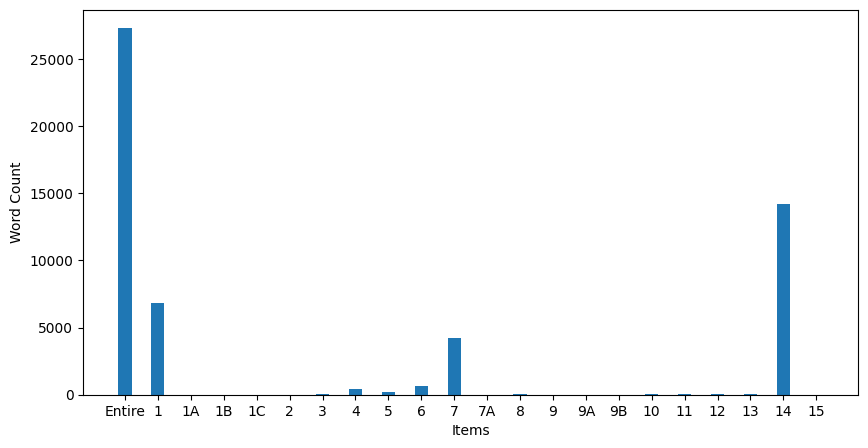

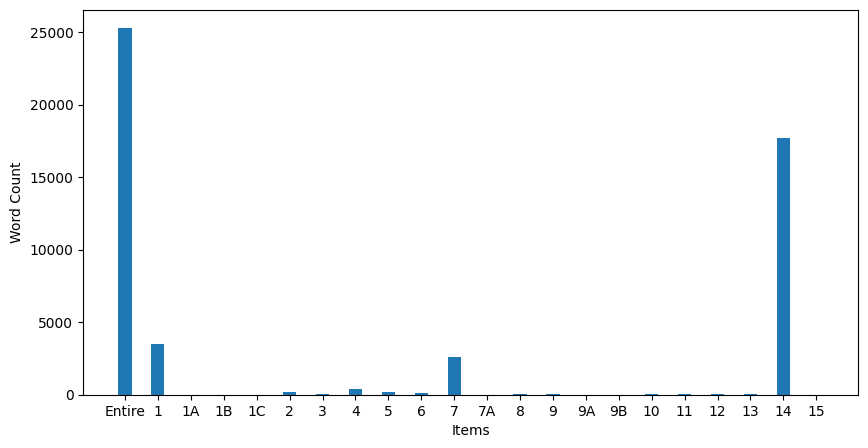

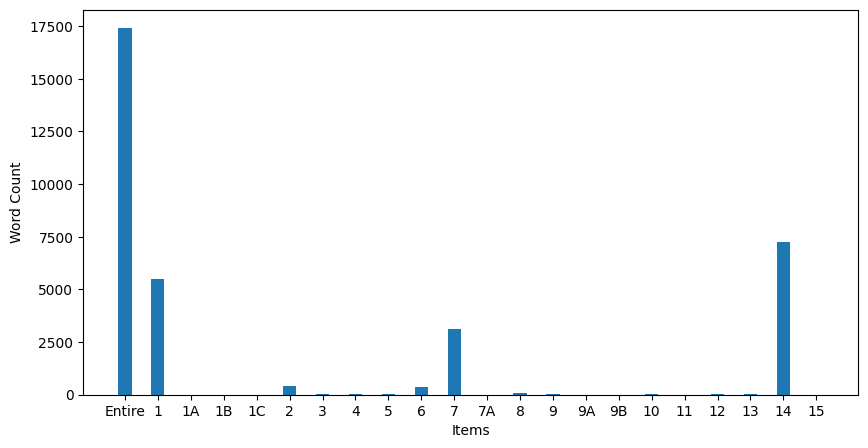

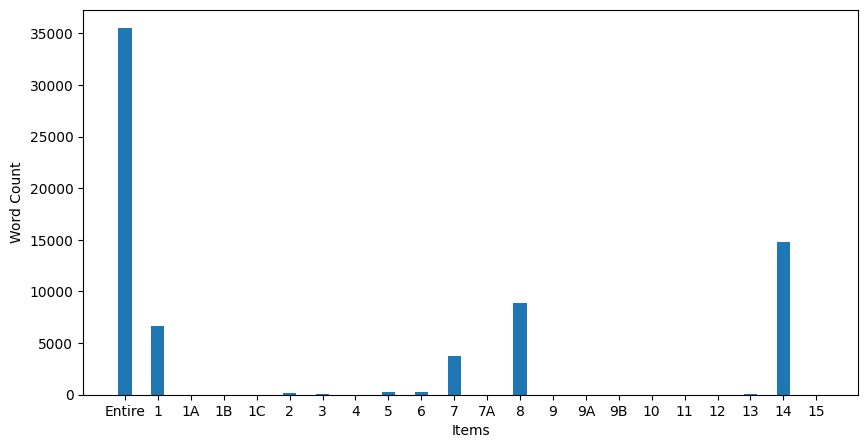

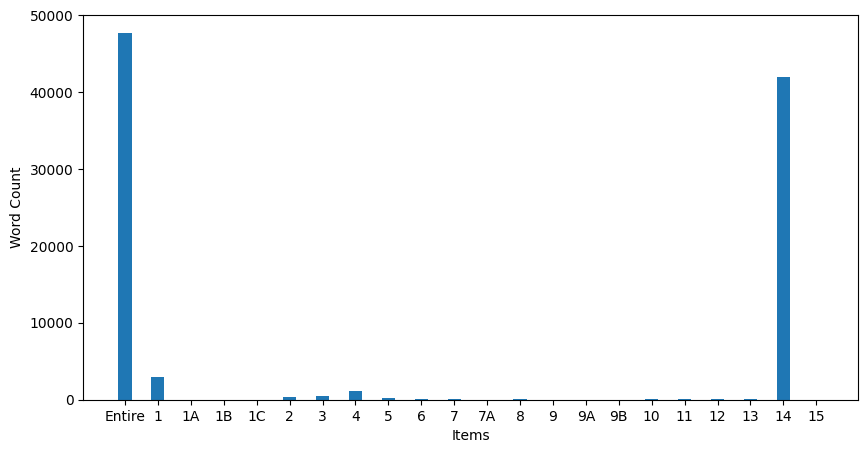

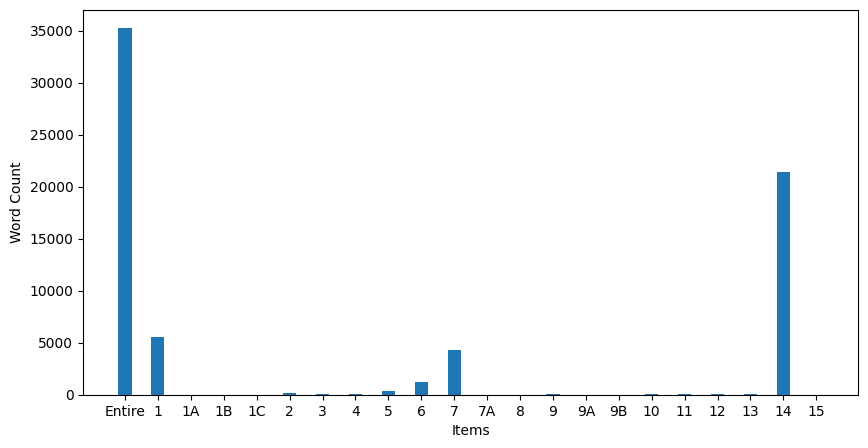

In [ ]:
# import matplotlib.pyplot as plt

# for data in ans:
#   items = list(data.keys())
#   counts = list(data.values())

#   fig = plt.figure(figsize = (10, 5))
#   plt.bar(items, counts, width = 0.4)

#   plt.xlabel("Items")
#   plt.ylabel("Word Count")
#   plt.show()